<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Plant-Material-Removal" data-toc-modified-id="Plant-Material-Removal-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Plant Material Removal</a></span></li></ul></li></ul></li><li><span><a href="#Bone-Marrow-Transplant" data-toc-modified-id="Bone-Marrow-Transplant-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bone Marrow Transplant</a></span><ul class="toc-item"><li><span><a href="#Source-Tracking" data-toc-modified-id="Source-Tracking-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Source Tracking</a></span><ul class="toc-item"><li><span><a href="#Test-Sourcetracker,-by-using-same-samples-for-source-AND-sink" data-toc-modified-id="Test-Sourcetracker,-by-using-same-samples-for-source-AND-sink-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Test Sourcetracker, by using same samples for source AND sink</a></span></li><li><span><a href="#Sourcetracker,-with-more-elaborate-Source-definitions,-i.e.-per-Timepoint-+-ETV6RUNX1" data-toc-modified-id="Sourcetracker,-with-more-elaborate-Source-definitions,-i.e.-per-Timepoint-+-ETV6RUNX1-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Sourcetracker, with more elaborate Source definitions, i.e. per Timepoint + ETV6RUNX1</a></span></li></ul></li><li><span><a href="#Use-a-Random-Forrest-to-predict-genotype-for-BMT-recipients" data-toc-modified-id="Use-a-Random-Forrest-to-predict-genotype-for-BMT-recipients-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Use a Random Forrest to predict genotype for BMT recipients</a></span></li><li><span><a href="#Irradiation-effect" data-toc-modified-id="Irradiation-effect-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Irradiation effect</a></span></li></ul></li><li><span><a href="#ETV6-RUNX1" data-toc-modified-id="ETV6-RUNX1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ETV6-RUNX1</a></span><ul class="toc-item"><li><span><a href="#SourceTracking-for-ETV6-RUNX1-samples-to-determin-if-they-are-closer-to-WT-or-Pax5+/-" data-toc-modified-id="SourceTracking-for-ETV6-RUNX1-samples-to-determin-if-they-are-closer-to-WT-or-Pax5+/--2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>SourceTracking for ETV6-RUNX1 samples to determin if they are closer to WT or Pax5+/-</a></span></li></ul></li><li><span><a href="#Metabolome" data-toc-modified-id="Metabolome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metabolome</a></span><ul class="toc-item"><li><span><a href="#Genotype" data-toc-modified-id="Genotype-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Genotype</a></span></li><li><span><a href="#Sick-/-Healthy" data-toc-modified-id="Sick-/-Healthy-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sick / Healthy</a></span></li></ul></li></ul></div>

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ["PROJ_LIB"] = "/homes/sjanssen/miniconda3/envs/notebookServer/share/proj"

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *
from ggmap.settings import *

from scipy.spatial import distance
from scipy.cluster import hierarchy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fp_workdir = 'Workdir/'
fp_generated = 'Generated/'
for fp in [fp_workdir, fp_generated]:
    os.makedirs(fp, exist_ok=True)

fps = {'meta': {'Cohousing': 'FromQiita/Cohousing/11758_20200514-235926.txt',
                'ABX': 'FromQiita/ABX/11953_20200515-024601.txt',
                'ETV6RUNX1': 'FromQiita/ETV6RUNX1/12981_20200515-024854.txt',
                'BMT': 'FromQiita/BMT/13189_20200519-000258.txt',
               },
       'prep': {'Cohousing': 'FromQiita/Cohousing/11758_prep_6209_20200514-235201.txt',
                'ABX': 'FromQiita/ABX/11953_prep_7261_20191003-073852.txt',
                'ETV6RUNX1': 'FromQiita/ETV6RUNX1/12981_prep_8464_20200515-000306.txt',
                'BMT': 'FromQiita/BMT/13189_prep_8948_20200514-233349.txt',
               },
       'deblur_150': {'Cohousing': 'FromQiita/Cohousing/67817_reference-hit.biom',
                      'ABX': 'FromQiita/ABX/75878_reference-hit.biom',
                      'ETV6RUNX1': 'FromQiita/ETV6RUNX1/86044_reference-hit.biom',
                      'BMT': 'FromQiita/BMT/90669_reference-hit.biom',
                     },
       'closedref_150': {'Cohousing': 'FromQiita/Cohousing/75886_otu_table.biom', # still wrong read size: currently using 250nt but once Qiita is done I should switch to 150nt
                         'ABX': 'FromQiita/ABX/79356_otu_table.biom',
                         'ETV6RUNX1': 'FromQiita/ETV6RUNX1/86040_otu_table.biom',
                         'BMT': 'FromQiita/BMT/90610_otu_table.biom',
                        },
       'workdir': {'combined_bioms': {'deblur': fp_workdir + 'deblur_all4.biom',
                                      'closedref': fp_workdir+'closedref_all4.biom'},
                   'insertion_tree': fp_workdir+'insertion_tree_4all.newick'},
      }
na_values=['not applicable', 'not provided', 'missing', 'not collected']

def _tp_short(timepoint):
    if timepoint == '10 month together':
        return 'tp10'
    elif timepoint == '1 month together in the same cage and condition':
        return 'tp01'
    else:
        return timepoint
    
def _savefig(fig, name):
    os.makedirs(fp_generated+'Figures/SVG', exist_ok=True)
    os.makedirs(fp_generated+'Figures/PNG', exist_ok=True)
    
    fig.savefig(fp_generated+'Figures/SVG/%s.svg' % name, bbox_inches='tight')
    fig.savefig(fp_generated+'Figures/PNG/%s.png' % name, bbox_inches='tight')


color_pax5 = '#8ac4e7'
color_wt = '#289d2c'
colors_permanova = {'intra: Pax5+/-': color_pax5, 'intra: WT': color_wt, 'inter': 'white'}
colors_srtr = {
    'CF@tp10@Pax5+/-': '#54278f',
    'CF@tp01@Pax5+/-': '#756bb1',
    'SPF@tp10@Pax5+/-': '#9e9ac8',
    'SPF@tp01@Pax5+/-': '#bcbddc',
    'CF@tp10@WT': '#a50f15',
    'CF@tp01@WT': '#de2d26',
    'SPF@tp10@WT': '#fb6a4a',
    'SPF@tp01@WT': '#fc9272',
    'Unknown': '#969696',}


In [3]:
meta = pd.concat([
    # read metadata
    pd.concat([pd.read_csv(file, sep="\t", dtype=str, na_values=na_values, index_col=0) for file in fps['meta'].values()], axis=0, sort=False),
    # read prep data
    pd.concat([pd.read_csv(file, sep="\t", dtype=str, na_values=na_values, index_col=0) for file in fps['prep'].values()], axis=0, sort=False).rename(columns={'description': 'description_prep'})
], sort=False, axis=1)

# one WT mice was accidentially called WT-8, but it should have been WT-9
# metadata are correct, but sample_name now is wrong (saving computation of everything)
# here I delete the metadata row with correct sample_name but wrong read assignments
meta.drop(index='11758.WT9.nr23.tp10', inplace=True)

# add a field "cage_genotype" that records if the sample stems from a cage with mixed genotypes or not
_cagegenotypes = meta.groupby('cage').apply(lambda x: ' and '.join(sorted(x['genotype'].unique()))).to_frame().rename(columns={0: 'cage_genotype'})
meta = meta.merge(_cagegenotypes, left_on='cage', right_index=True, how='left')

# add a field combining facility and qiita_study_id to ease coloring in emperor
meta['study@facility'] = meta['qiita_study_id'] + '@' + meta['facility']

# let us use a specific column to indicate samples of mice who developed B cell neoplasia ...
meta.loc[:, 'b_cell_neoplasia'] = False
meta.loc[meta[meta['diseased'] == 'B cell neoplasia'].index, 'b_cell_neoplasia'] = True
# which seems to be normal for mice in labs: 10.1016/j.etp.2006.01.007 and change the diseased status to NO
meta.loc[meta[meta['diseased'] == 'B cell neoplasia'].index, 'diseased'] = 'no'
meta['diseased'] = meta['diseased'].fillna('no')

# boolean variable to indicate if mice of the ABX experiment have ever been transferred to CF
meta['transferred_to_CF'] = pd.notnull(meta['exposure_to_infections'])

# for PacBio data, I saw a larger separation by cages
meta['cage_group'] = meta['cage'].apply(lambda x: {
    '#c3d69b.green': 'green+magenta',
    '#dce6f1.blue': 'blue+orange',
    '#fac090.orange': 'blue+orange',
    '#ff99ff.magenta': 'green+magenta',
    '#ffff99.yellow': None}.get(x, None))


# normalize date formats
for c in ['antibiotics_treatment_end_timestamp',
          'antibiotics_treatment_start_timestamp',
          'birth_timestamp',
          'cage_timestamp',
          'date_of_shipment',
          'death_timestamp',
          'exposure_to_infections',
          'facs_timestamp',
          'collection_timestamp',
          'start_cohousing_timestamp',
          'run_date',
          'bone_marrow_transplant_timestamp']:
    meta[c] = pd.to_datetime(meta[c])

# normalize float data
for c in ['host_age',
          'elevation',
          'facs_peripheralblood_bcells',
          'latitude',
          'longitude',
          'stool_dna_concentration',
          'timepoint_weeks',
          'weight_stool',
          'weight_stool_pbs']:
    meta[c] = meta[c].astype(float)
    
# for each mouse, compute the past time between collecting the first sample and this sample
for (study, hsid), g in meta.sort_values(by='collection_timestamp').groupby(['cohort', 'host_subject_id']):
    tp_init = g.iloc[0].loc['collection_timestamp']
    delta = (g['collection_timestamp'] - tp_init).apply(lambda x: int(x.days) if pd.notnull(x) else x)
    meta.loc[g.index[0], 'days_to_init'] = 0
    meta.loc[delta.index, 'days_to_init'] = delta
    if study == 'ABX':
        meta.loc[g[g['timepoint_weeks'] == 0].index, 'tp_title'] = 'pre-abx'
        meta.loc[g[g['timepoint_weeks'].isin([4, 8])].index, 'tp_title'] = 'abx'
        meta.loc[g[g['timepoint_weeks'] > 8].index, 'tp_title'] = 'post-abx'
        #print(study, hsid, g[pd.isnull(g['timepoint_weeks']) & (g['timepoint_title'] == 'death')].shape[0])
        meta.loc[g[pd.isnull(g['timepoint_weeks']) & (g['timepoint_title'] == 'death')].index, 'tp_title'] = 'death'
    elif study == 'cohousing':
        meta.loc[g[g['timepoint_title'] == '1 month together in the same cage and condition'].index, 'tp_title'] = '1 month together'
        meta.loc[g[g['timepoint_title'] == '10 month together'].index, 'tp_title'] = '10 months together'
# bin samples into 5 weeks intervals
meta['tp_bin35'] = meta['days_to_init'].dropna().apply(lambda x: 0 if x == 0 else math.ceil(x/35)*5)
meta['tp_bin35_title'] = meta['tp_bin35'].apply(lambda x: "" if pd.isna(x) else "%i weeks" % x)
meta.loc[meta[meta['timepoint_title'] == 'death'].index, 'tp_bin35_title'] = 'at death'
meta['tp_short_title'] = meta['timepoint_title'].apply(_tp_short)

In [4]:
# load deblur feature data
counts_deblur = pd.concat([biom2pandas(file) for file in fps['deblur_150'].values()], axis=1, sort=False).fillna(0)

# load closedref feature data
counts_closedref = pd.concat([biom2pandas(file) for file in fps['closedref_150'].values()], axis=1, sort=False).fillna(0)

if not os.path.exists(fps['workdir']['combined_bioms']['deblur']):
    pandas2biom(fps['workdir']['combined_bioms']['deblur'], counts_deblur)
if not os.path.exists(fps['workdir']['combined_bioms']['closedref']):
    pandas2biom(fps['workdir']['combined_bioms']['closedref'], counts_closedref)


# create one shared insertion tree
res_sepp = sepp(counts_deblur, chunksize=3000, ppn=10, dry=False, wait=False)
if not os.path.exists(fps['workdir']['insertion_tree']):
    with open(fps['workdir']['insertion_tree'], 'w') as f:
        f.write(res_sepp['results']['tree'].replace('k__Bacteria)', 'k__Bacteria:0.0)')+"\n")
%time insertion_tree = TreeNode.read(fps['workdir']['insertion_tree'])

Using existing results from '.anacache/69f793360e672ef1fc94b07b22dbdf2d.sepp'. 


CPU times: user 14.1 s, sys: 354 ms, total: 14.5 s
Wall time: 14.5 s


In [5]:
res_all = process_study(
    metadata=meta,
    control_samples=set(meta[meta['sample_type'].isin(['water control', 'control blank', 'control mock'])].index),
    fp_deblur_biom=fps['workdir']['combined_bioms']['deblur'],
    fp_insertiontree=fps['workdir']['insertion_tree'],
    fp_closedref_biom=fps['workdir']['combined_bioms']['closedref'],
    rarefaction_depth=35000,
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-515-806-nb-classifier_2020.2.qza',
    tree_insert=insertion_tree,
    is_v4_region=True,
    fix_zero_len_branches=False,
    emperor_fp=fp_generated+'/Emperor/',
    emperor_infix='_all4_',
    dry=False,
    #deblur_remove_features_lessthanXreads=10, # as this is now the default
)

print('Overall, the study recovered %s sOTUs (from %s samples)' % res_all['rarefaction']['results'].shape)

Information: 83661 of 90090 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/5fef12dc2de8286f8e31c0adbdd1b35a.taxRDP'. 
Information: You are loosing a significant amount of reads due to filtration of plant material!
11953.A732.tp08           0.988854
11953.F319.tp04           0.988805
11953.A428.tp08           0.985974
11953.FOOD.SPF.box2.29    0.985295
11953.A707.tp08           0.985122
11953.FOOD.SPF.box2.30    0.983915
11953.A879.tp04           0.983752
11953.A431.tp04           0.983331
11953.A429.tp04           0.982651
11953.F323.tp04           0.982642
dtype: float64
Using existing results from '.anacache/a2f0c93f57393036b3eba1c138510031.rare'. 
Using existing results from '.anacache/db732a4c8a35ea701f965f778f7653e1.rarefy'. 
Using existing results from '.anacache/30ad69110dab0b66cb7c6b8a6d6323ee.adiv'. 
Using existing results from '.anacache/54385e36601b82905e12096d21be702

Overall, the study recovered 3978 sOTUs (from 657 samples)


### Plant Material Removal
For the co-housing cohort: Plot a graph that indicates the big impact of read count removal, if features are assigned taxonomic labels belonging to mitochondria or chloroplasts

In [6]:
sample_counts = pd.concat([
    res_all['counts_plantsremoved'].sum(axis=0).to_frame().rename(columns={0: 'filtered reads'}),
    res_all['counts_plantsStillIn'].sum(axis=0).to_frame().rename(columns={0: 'all reads'})], axis=1, sort=False).merge(
        meta[['tp_bin35', 'cohort']], left_index=True, right_index=True, how='left')
# restrict to the ABX cohort only
sample_counts = sample_counts[sample_counts['cohort'] == 'ABX']
# transform data
sample_counts = sample_counts.reset_index().set_index(['index', 'tp_bin35', 'cohort']).stack().reset_index()
sample_counts['tp_bin35'] = sample_counts['tp_bin35'].astype(int)

fig, axes = plt.subplots(1,1, figsize=(10, 5))
g = sns.barplot(data=sample_counts, y=0, x='tp_bin35', hue='level_3', ax=axes, hue_order=['all reads', 'filtered reads'])
axes.set_ylabel('absolute read counts')
axes.set_xlabel('weeks')
axes.get_legend().set_title('')

# Bone Marrow Transplant
Study Design

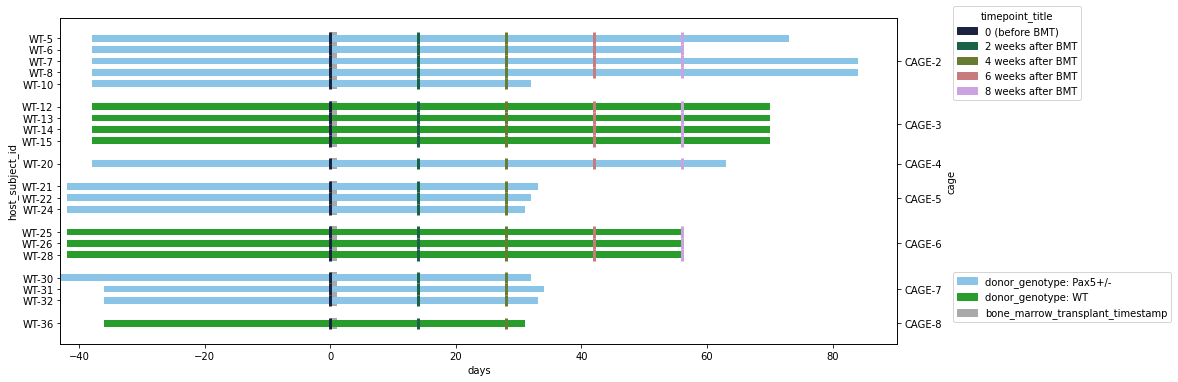

In [26]:
meta_bmt = meta[meta['cohort'] == 'BMT'].copy()
meta_bmt['bone_marrow_transplant_timestamp_END'] = meta_bmt['bone_marrow_transplant_timestamp'] + pd.DateOffset(days=1)

x = ganttChart(meta_bmt, 
               col_birth='birth_timestamp', 
               col_entities='host_subject_id', 
               col_events='collection_timestamp',
               col_death='death_timestamp', 
               col_events_title='timepoint_title', 
               col_entity_groups='cage',
               col_entity_colors='donor_genotype', 
               order_entities=['WT-5', 'WT-6', 'WT-7', 'WT-8', 'WT-10', 'WT-12', 'WT-13', 'WT-14', 'WT-15', 'WT-20', 'WT-21', 'WT-22', 'WT-24', 'WT-25', 'WT-26', 'WT-28', 'WT-30', 'WT-31', 'WT-32', 'WT-36'],
               col_phases_start=['bone_marrow_transplant_timestamp'], 
               col_phases_end=['bone_marrow_transplant_timestamp_END'],
               colors_entities={'Pax5+/-': color_pax5, 'WT': color_wt}, 
               colors_events={k:v for (k,v) in zip(list(meta_bmt.sort_values('timepoint_weeks')['timepoint_title'].unique()), sns.color_palette("cubehelix", 6))},
               #colors_entities=colors_permanova, 
               event_line_width=3,
               colors_phases={'bone_marrow_transplant_timestamp': 'darkgray'},
               align_to_event_title='0 (before BMT)',
               counts=res_all['rarefaction']['results'],
              )[0]

**From Carolina:**

Reviewer 3 suggested the following: "It remains unclear if a Pax5 haploinsuffiency mosaicism in the bone marrow, which would more faithfully reflect the presence or rare preleukemic cells, would be sufficient for development of ALL upon microbiome depletion. To address this question, the authors should include an experiment, where Pax5+/- HSPCs were transplanted into wt mice followed by antibiotic treatment. Either outcome would provide important information about the role genetic predisposition components outside the preleukemic compartment."
 
  - The treatment with antibiotics and the follow up of these mice is not possible as it would last 2 additional years.

  - Thus, the idea is trying to see if the different gut microbiome related to Pax5-het mice is also established in transplanted WT mice after BMT transplant from Pax5-het mice. 
    1. So the first step would be to compare the gut microbiome from mice transplanted with different donor-genotype (WT or Pax5). 
    1. If they were different, the next step would be to see if the microbiome from mice transplanted with Pax5 BMT resembled the specific gut microbiome already described in Pax5+/-. 

,0
0,too few samples


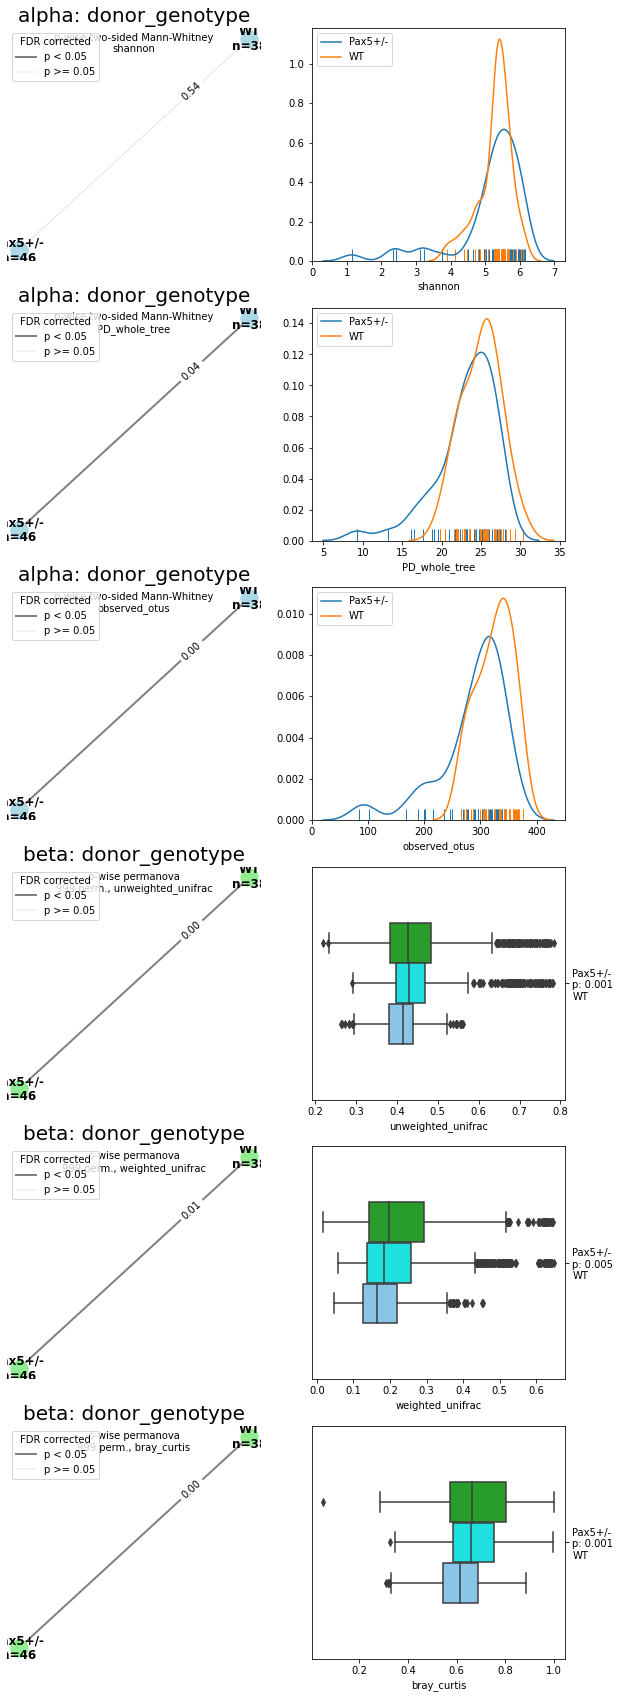

In [27]:
plotNetworks('donor_genotype', meta_bmt, res_all['alpha_diversity']['results'], res_all['beta_diversity']['results'], summarize=False)[0]

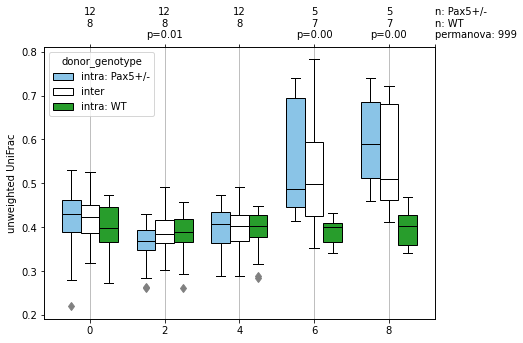

In [28]:
metric = 'unweighted_unifrac'
beta_changes_init = []
for hsid, g in meta[meta['cohort'] == 'BMT'].sort_values(by='timepoint_weeks').groupby('host_subject_id'):
    idx_timecourse = [idx for idx in g.index if idx in res_all['beta_diversity']['results'][metric].ids]
    idx_basis = g.index
    if (len(idx_basis) > 0) and (idx_basis[0] in res_all['beta_diversity']['results'][metric].ids):
        for idx in idx_timecourse:
            beta_changes_init.append({'sample_name': idx,
                                      'metric': metric,
                                      'distance': res_all['beta_diversity']['results'][metric][idx_basis[0], idx]})
beta_changes_init = pd.DataFrame(beta_changes_init).pivot(index='sample_name', columns='metric', values='distance')


if False:
    fig, axes = plt.subplots(2,1, figsize=(7, 10))
else:
    fig, axes = plt.subplots(1,1, figsize=(7, 5))
plot_timecourse_beta(meta[meta['cohort'] == 'BMT'], 
                     res_all['beta_diversity']['results']['unweighted_unifrac'], 
                     metric_name='unweighted UniFrac', 
                     col_events='timepoint_weeks', 
                     col_groups='donor_genotype', ax=axes,
                     colors_groups={'Pax5+/-': color_pax5, 'WT': color_wt})

if False:
    plot_timecourse(meta[meta['cohort'] == 'BMT'],
                    beta_changes_init['unweighted_unifrac'],
                    'timepoint_weeks', 
                    'host_subject_id', 
                    cols_groups=['donor_genotype'], 
                    colors_groups={'Pax5+/-': color_pax5, 'WT': color_wt}, 
                    ax=axes[1], 
                   )

## Source Tracking
Check if BMT recipients resemble more stereotypic microbiomes than their original SPF WT context.

--> BMT does not 100% override microbiome. Pax5+/- always present, but WT is significantly smaller in Pax5+/- recipients.

--> Did a control experiment with SourceTracker2: using same samples for source AND sink. Even than, sinks are not 100% of their sources. Points to inter sample variability.

--> to my surprise, SourceTracker2 finds ETV6-RUNX1 to be best resembled BMT samples.

--> FEAST results should be ignored

In [29]:
# define source samples:
# we use all single genotype cages from the cohousing experiment, i.e. WT and Pax5+/- at two time points in SPF
# + ETV5RUNX1 mice in SPF
# SPF, since BMT mice were housed in SPF
idx_pax5_wt_sources = meta[
    (meta['cohort'] == 'cohousing') & 
    (meta['cage_genotype'].isin(['WT', 'Pax5+/-'])) & 
    (meta['facility'] == 'SPF')].index

idx_etv6runx1_sources = meta[
    (meta['cohort'] == 'ETV6RUNX1') & (meta['facility'] == 'SPF')].index

# clear potential prev definitions:
meta.loc[:, 'st_env_name'] = None
meta.loc[:, 'st_sourcesink'] = None

#meta.loc[idx_etv6runx1_sources, 'st_env_name'] = meta.loc[idx_etv6runx1_sources, ['facility', 'genotype']].apply(lambda row: '#'.join(row), axis=1)
meta.loc[idx_pax5_wt_sources, 'st_env_name'] = meta.loc[idx_pax5_wt_sources, 'genotype']
meta.loc[idx_pax5_wt_sources, 'st_sourcesink'] = 'Source'

# define all BMT samples as sinks
idx_bmt_sinks = meta[meta['cohort'] == 'BMT'].index
meta.loc[idx_bmt_sinks, 'st_sourcesink'] = 'Sink'
meta.loc[idx_bmt_sinks, 'st_env_name'] = ''

meta.groupby(['st_sourcesink', 'st_env_name']).size()

st_sourcesink  st_env_name
Sink                          84
Source         Pax5+/-        12
               WT             12
dtype: int64

Reduced to 106 samples (feature-table had 657, metadata had 108 samples)
Using existing results from '.anacache/cf30e4f628bf9af1236f222c8a7d92b8.sourcetracker2'. 


84 samples left with metadata and counts.
3 taxa left after restricting to provided list.
raw counts: 84
raw meta: 1041
meta with counts: 10 samples x 4 fields
counts with meta: 10


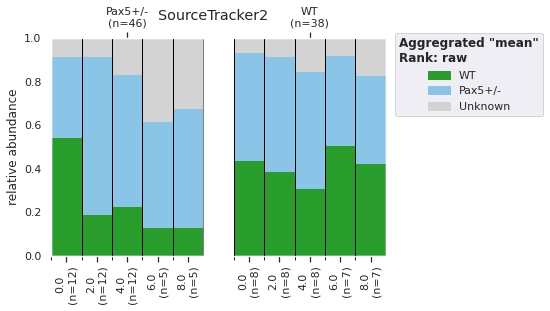

In [31]:
res_st2 = sourcetracker2(res_all['rarefaction']['results'], meta[pd.notnull(meta['st_sourcesink'])], col_envname='st_env_name', col_type='st_sourcesink', dry=False, wait=False)
p = plotTaxonomy(res_st2['results'], meta, file_taxonomy=pd.Series(), rank='raw', minreadnr=0,
                 group_l0='donor_genotype', group_l1='timepoint_weeks', fct_aggregate=np.mean, print_sample_labels=False,
                 colors={'Pax5+/-': color_pax5, 'WT': color_wt, 'Unknown': 'lightgray'}, 
                 plottaxa=['WT', 'Pax5+/-', 'Unknown'], reorder_taxa=False)
_ = p[0].suptitle('SourceTracker2')

Reduced to 106 samples (feature-table had 657, metadata had 108 samples)
Using existing results from '.anacache/73caa2e4265562d67913d9a19e8991c6.feast'. 


84 samples left with metadata and counts.
3 taxa left after restricting to provided list.
raw counts: 84
raw meta: 1041
meta with counts: 10 samples x 4 fields
counts with meta: 10


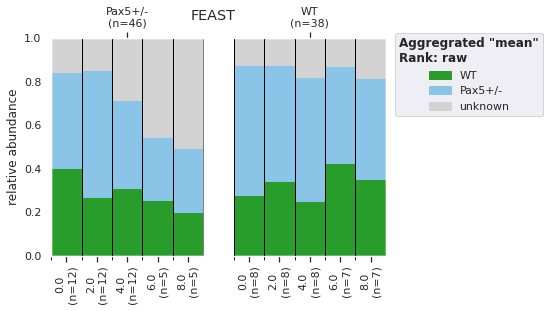

In [33]:
res_feast = feast(res_all['rarefaction']['results'], meta[pd.notnull(meta['st_sourcesink'])], col_envname='st_env_name', col_type='st_sourcesink', dry=False, wait=False)
p = plotTaxonomy(res_feast['results'], meta, file_taxonomy=pd.Series(), rank='raw', minreadnr=0,
                 group_l0='donor_genotype', group_l1='timepoint_weeks', fct_aggregate=np.mean, print_sample_labels=False,
                 colors={'Pax5+/-': color_pax5, 'WT': color_wt, 'unknown': 'lightgray'},
                 plottaxa=['WT', 'Pax5+/-', 'unknown'], reorder_taxa=False
                )
_ = p[0].suptitle('FEAST')

Can we observe significant differences when turning to beta-distances?
Compare all distances from stereotypic Pax5+/- mice to Pax5+/- BMT recipients VS WT BMT recipients.

--> differences are significant, but I figure this is a result of large numbers. The mean distance is extremely close AND points towards the wrong direction.

Mean distance Pax5+/- source <-> Pax5+/- sink: 0.5048
Mean distance WT source <-> Pax5+/- sink: 0.4985


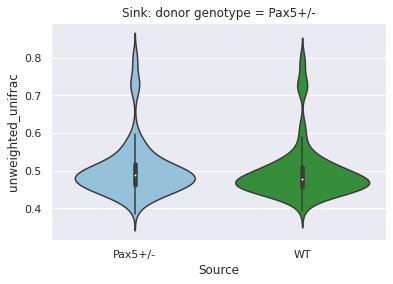

In [34]:
dm_flat = res_all['beta_diversity']['results']['unweighted_unifrac'].filter(meta[pd.notnull(meta['st_sourcesink'])].index, strict=False).to_data_frame().stack().reset_index().rename(columns={'level_0': 'x', 'level_1': 'y', 0: 'unweighted_unifrac'})
# double merge with metadata
dm_flat = dm_flat.merge(meta, left_on='x', right_index=True).merge(meta, left_on='y', right_index=True)
# remove self distances
dm_flat = dm_flat[dm_flat['x'] != dm_flat['y']]

dm_flat_donorpax5 = dm_flat[(dm_flat['st_sourcesink_x'] == 'Source') & (dm_flat['st_sourcesink_y'] == 'Sink') & 
                            (dm_flat['donor_genotype_y'] == 'Pax5+/-')]
g = sns.violinplot(data=dm_flat_donorpax5, y='unweighted_unifrac', x='st_env_name_x', palette={'Pax5+/-': color_pax5, 'WT': color_wt})
g.set_xlabel('Source')
g.set_title('Sink: donor genotype = Pax5+/-')
mannwhitneyu(dm_flat_donorpax5[dm_flat_donorpax5['st_env_name_x'] == 'Pax5+/-']['unweighted_unifrac'], 
             dm_flat_donorpax5[dm_flat_donorpax5['st_env_name_x'] == 'WT']['unweighted_unifrac'],
             alternative='two-sided')
print('Mean distance Pax5+/- source <-> Pax5+/- sink: %.4f\nMean distance WT source <-> Pax5+/- sink: %.4f' % 
      (dm_flat_donorpax5[dm_flat_donorpax5['st_env_name_x'] == 'Pax5+/-']['unweighted_unifrac'].mean(), 
       dm_flat_donorpax5[dm_flat_donorpax5['st_env_name_x'] == 'WT']['unweighted_unifrac'].mean()))

### Test Sourcetracker, by using same samples for source AND sink
I want to check how well SourceTracker identifies genotype specific samples as self, to get an estimate about the uncertainty observed above.

In [35]:
# define source samples:
# we use all single genotype cages from the cohousing experiment, i.e. WT and Pax5+/- at two time points in SPF
# + ETV5RUNX1 mice in SPF
# SPF, since BMT mice were housed in SPF
idx_pax5_wt_sources = meta[
    (meta['cohort'] == 'cohousing') & 
    (meta['cage_genotype'].isin(['WT', 'Pax5+/-'])) & 
    (meta['facility'] == 'SPF')].index

idx_etv6runx1_sources = meta[
    (meta['cohort'] == 'ETV6RUNX1') & (meta['facility'] == 'SPF')].index

# clear potential prev definitions:
mt = meta.copy()
mt.loc[:, 'st_env_name'] = None
mt.loc[:, 'st_sourcesink'] = None

#meta.loc[idx_etv6runx1_sources, 'st_env_name'] = meta.loc[idx_etv6runx1_sources, ['facility', 'genotype']].apply(lambda row: '#'.join(row), axis=1)
mt.loc[idx_pax5_wt_sources, 'st_env_name'] = mt.loc[idx_pax5_wt_sources, 'genotype']
mt.loc[idx_pax5_wt_sources, 'st_sourcesink'] = 'Source'

# define all BMT samples as sinks
idx_bmt_sinks = mt[mt['cohort'] == 'BMT'].index
mt.loc[idx_bmt_sinks, 'st_sourcesink'] = 'Sink'
mt.loc[idx_bmt_sinks, 'st_env_name'] = ''

mtadd = mt.loc[idx_pax5_wt_sources, :].copy()
mtadd.index = list(map(lambda x: 'fake.%s' % x, mtadd.index))
mtadd['st_sourcesink'] = 'Sink'
mtadd['st_env_name'] = ''
mt = pd.concat([mt, mtadd], axis=0)
ct = res_all['rarefaction']['results'].loc[:, idx_pax5_wt_sources].copy()
ct.columns = list(map(lambda x: 'fake.%s' % x, ct.columns))
ct = pd.concat([res_all['rarefaction']['results'], ct], sort=False, axis=1).fillna(0)

mt.groupby(['st_sourcesink', 'st_env_name']).size()

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


st_sourcesink  st_env_name
Sink                          108
Source         Pax5+/-         12
               WT              12
dtype: int64

24 samples left with metadata and counts.
raw counts: 24
raw meta: 24
meta with counts: 24 samples x 114 fields
counts with meta: 24


Reduced to 130 samples (feature-table had 681, metadata had 132 samples)
Using existing results from '.anacache/ea2ad79870092809dea15ec83f3e9ce7.sourcetracker2'. 


Text(0.5, 0.98, 'SourceTracker2: control')

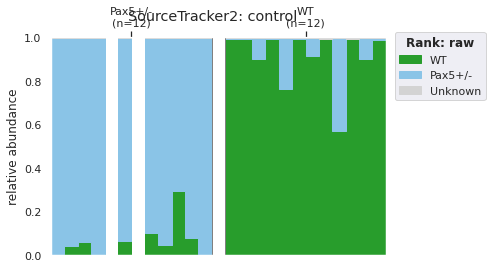

In [37]:
res_st2_control = sourcetracker2(ct, mt[pd.notnull(mt['st_sourcesink'])], col_envname='st_env_name', col_type='st_sourcesink', dry=True, wait=False)
idx_go = [i for i in mt.index if 'fake' in i]
p = plotTaxonomy(res_st2_control['results'].loc[:, idx_go], mt.loc[idx_go, :], file_taxonomy=pd.Series(), rank='raw', minreadnr=0,
                 group_l1='genotype', #group_l2='timepoint_weeks', 
                 colors={'Pax5+/-': color_pax5, 'WT': color_wt, 'Unknown': 'lightgray'},
                 #fct_aggregate=np.mean, 
                 #print_sample_labels=True
                )
p[0].suptitle('SourceTracker2: control')

### Sourcetracker, with more elaborate Source definitions, i.e. per Timepoint + ETV6RUNX1

In [38]:
# define source samples:
# we use all single genotype cages from the cohousing experiment, i.e. WT and Pax5+/- at two time points in SPF
# + ETV5RUNX1 mice in SPF
# SPF, since BMT mice were housed in SPF
idx_pax5_wt_sources = meta[
    (meta['cohort'] == 'cohousing') & 
    (meta['cage_genotype'].isin(['WT', 'Pax5+/-'])) & 
    (meta['facility'] == 'SPF')].index

idx_etv6runx1_sources = meta[
    (meta['cohort'] == 'ETV6RUNX1') & (meta['facility'] == 'SPF')].index

# clear potential prev definitions:
meta.loc[:, 'st_env_name'] = None
meta.loc[:, 'st_sourcesink'] = None

meta.loc[idx_etv6runx1_sources, 'st_env_name'] = meta.loc[idx_etv6runx1_sources, ['facility', 'genotype']].apply(lambda row: '#'.join(row), axis=1)
meta.loc[idx_pax5_wt_sources, 'st_env_name'] = meta.loc[idx_pax5_wt_sources, ['facility', 'genotype', 'tp_short_title']].apply(lambda row: '#'.join(row), axis=1)
meta.loc[list(idx_pax5_wt_sources) + list(idx_etv6runx1_sources), 'st_sourcesink'] = 'Source'

# define all BMT samples as sinks
idx_bmt_sinks = meta[meta['cohort'] == 'BMT'].index
meta.loc[idx_bmt_sinks, 'st_sourcesink'] = 'Sink'
meta.loc[idx_bmt_sinks, 'st_env_name'] = ''

meta.groupby(['st_sourcesink', 'st_env_name']).size()

st_sourcesink  st_env_name     
Sink                               84
Source         SPF#ETV6-RUNX1      12
               SPF#Pax5+/-#tp01     6
               SPF#Pax5+/-#tp10     6
               SPF#WT#tp01          6
               SPF#WT#tp10          6
dtype: int64

Reduced to 118 samples (feature-table had 657, metadata had 120 samples)
Using existing results from '.anacache/0cc0fad0b68f5bc25e1fc63752aa10cc.sourcetracker2'. 


84 samples left with metadata and counts.
6 taxa left after restricting to provided list.
raw counts: 84
raw meta: 1041
meta with counts: 10 samples x 4 fields
counts with meta: 10


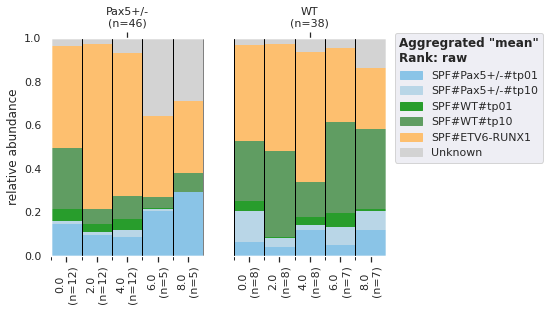

In [40]:
res_st2_withetv = sourcetracker2(res_all['rarefaction']['results'], meta[pd.notnull(meta['st_sourcesink'])], col_envname='st_env_name', col_type='st_sourcesink', dry=False, wait=False)

p = plotTaxonomy(res_st2_withetv['results'], meta, file_taxonomy=pd.Series(), rank='raw', minreadnr=0,
                 group_l0='donor_genotype', group_l1='timepoint_weeks', fct_aggregate=np.mean, print_sample_labels=False,
                 colors={'Unknown': 'lightgray', 'SPF#Pax5+/-#tp01': color_pax5, 'SPF#WT#tp01': color_wt,
                                                 'SPF#Pax5+/-#tp10': '#b9d6e7',  'SPF#WT#tp10': '#609d62'},
                 plottaxa=['SPF#Pax5+/-#tp01', 'SPF#Pax5+/-#tp10', 'SPF#WT#tp01', 'SPF#WT#tp10', 'SPF#ETV6-RUNX1', 'Unknown'], reorder_taxa=False)

## Use a Random Forrest to predict genotype for BMT recipients

--> very poor performance, i.e. it does not work at all!

We first use the random forest on best 40 V4 features which was very successful in previous experiments...

identify_important_features: retrieved results from cache "Workdir//rf_genotype_50-50.cache".


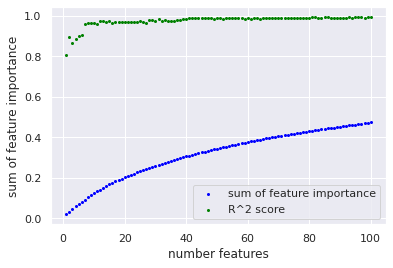

In [41]:
res_randomforest = identify_important_features(
    meta[meta['cage_genotype'].isin(['Pax5+/-', 'WT']) & (~meta['timepoint_weeks'].isin([4.0, 8.0]))]['genotype'],
    res_all['rarefaction']['results'],
    test_size=0.5, num_trees=1000, cache_filename="%s/rf_genotype_50-50.cache" % fp_workdir)
prf = plot_identify_important_features(res_randomforest)

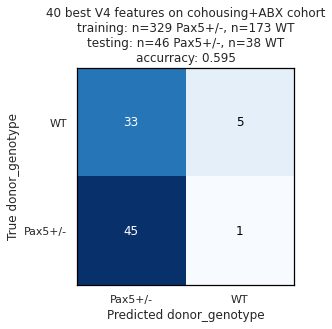

In [42]:
idx_features = res_randomforest.iloc[40-1,:].loc['features']
idx_training = set(meta[meta['cage_genotype'].isin(['Pax5+/-', 'WT']) & (~meta['timepoint_weeks'].isin([4.0, 8.0])) & (meta['cohort'] != 'BMT')]['genotype'].index) & set(res_all['rarefaction']['results'].columns)
idx_test = set(meta[meta['cohort'] == 'BMT'].index) & set(res_all['rarefaction']['results'].columns)
clf = RandomForestClassifier(n_estimators=1000, n_jobs=1, random_state=42)
clf = clf.fit(res_all['rarefaction']['results'].loc[idx_features, idx_training].T, meta.loc[idx_training, 'genotype'])

X_test = res_all['rarefaction']['results'].loc[idx_features, list(idx_test)].T
y_test = meta.loc[list(idx_test), 'donor_genotype']
accurracy = clf.score(X_test, y_test)

prediction = pd.Series(clf.predict(X_test), index=list(idx_test))
prediction.value_counts()

_ = plot_confusion_matrix(meta.loc[prediction.index, 'donor_genotype'],
                      prediction,
                      title='40 best V4 features on cohousing+ABX cohort\ntraining: n=%i Pax5+/-, n=%i WT\ntesting: n=%i Pax5+/-, n=%i WT\naccurracy: %.3f' % (
                          meta.loc[idx_training, 'genotype'].value_counts()['Pax5+/-'],
                          meta.loc[idx_training, 'genotype'].value_counts()['WT'],
                          y_test.value_counts()['Pax5+/-'], 
                          y_test.value_counts()['WT'], 
                          accurracy), normalize=False, verbose=None,
                      )

... and than use another random forest on ALL features, hoping that additional information might ease the problem - but that is not the case

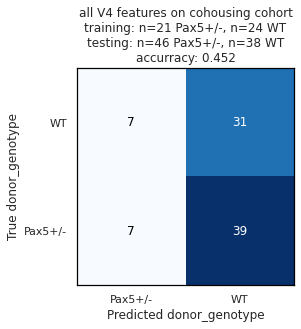

In [43]:
idx_training = set(meta[(meta['cohort'] == 'cohousing') & (meta['cage_genotype'].isin(['WT', 'Pax5+/-']))].index) & set(res_all['rarefaction']['results'].columns)
idx_test = set(meta[meta['cohort'] == 'BMT'].index) & set(res_all['rarefaction']['results'].columns)
clf = clf.fit(res_all['rarefaction']['results'].loc[:, idx_training].T, meta.loc[idx_training, 'genotype'])

X_test = res_all['rarefaction']['results'].loc[:, list(idx_test)].T
y_test = meta.loc[X_test.index, 'donor_genotype']
accurracy = clf.score(X_test, y_test)
prediction = pd.Series(clf.predict(X_test), index=list(idx_test))

plot_confusion_matrix(meta.loc[prediction.index, 'donor_genotype'],
                      prediction,
                      title='all V4 features on cohousing cohort\ntraining: n=%i Pax5+/-, n=%i WT\ntesting: n=%i Pax5+/-, n=%i WT\naccurracy: %.3f' % (
                          meta.loc[idx_training, 'genotype'].value_counts()['Pax5+/-'],
                          meta.loc[idx_training, 'genotype'].value_counts()['WT'],
                          y_test.value_counts()['Pax5+/-'], 
                          y_test.value_counts()['WT'], 
                          accurracy), normalize=False, verbose=None,
                      )

## Irradiation effect
**Arndt Borkhardt**
@Stefan, I think it would be good to analysis the sole effect of BMT/irradiation by looking at WT on WT…microbiomes in detail.
 
Does the WT microbiome after BMT look like WT before? This would be in sharp contrast to what’s known from human studies.

What I would like to say is: We have to have some ideas how irradation/conditioning affects the microbiome by itself in our model?

As it seems that the microbiome after transplantation from pax5 +/- to WT comes similarly to the ETV6/Runx1 microbiome makes it surprisingly complicated.

For the rebuttle, I think we should keep it simple and the key message is that the transplantation of pax5 +/- cells to WT animals results in a different microbiome. This is, however,perhaps not a big surprise as the BMT procedure itself (irradation) shapes the microbiome tremendously. There are many human studies done on this topic.

Thus, this „extend of change“ are due to 1. the BMT procedere itself and 2. the pax5 +/- cells

Intuitively spoken, the massive changes may mainly come because of the irradition and to much lesser extend due to the pax5 +/- cells.

Can we separate these two effects from each other?

In summary and if so:
  1.       I would expect that WT microbiome differs profoundly before and after BMT, simply because of the procedure and in accordance with human BMT data.

  2.       The genuine pax 5 +/- microbiome (we defined before) cannot fully be resembled in WT animals, even if they were transplanted with pax5 +/- cells.   


@Stefan, I think it would be crucially important to describe the „irradiation-only“ (e.g. „BMT-only“) effect on microbiome by looking at WT-WT cohort in more detail.
As I said yesterday, a significant bunch of studies have been published in humans, which may serve as indicator how profoundly microbiome changes pre/after BMT. Might be different in mice but changes are unavoidable. Could even be that mice BMT studies have been done?

Please re-check what referees asked for the rebuttle. We should closely stick to their advice only. 


https://pubmed.ncbi.nlm.nih.gov/31116852/?from_term=Mice+irradiation+microbiome&from_sort=date&from_page=2&from_pos=8

Dear all,

I shortly checked the keywords „mice + irradiation + microbiome“ in PubMed.

Many studies appear  - some of them may deserve a closer look at.

Best

In [44]:
# flatten distance matrix and join with metadata
dist_meta = res_all['beta_diversity']['results']['unweighted_unifrac'].to_data_frame().stack().reset_index().rename(columns={'level_0': 'sample_name_x', 'level_1': 'sample_name_y', 0: 'unweighted_unifrac'}).merge(meta, left_on='sample_name_x', right_index=True, how='left').merge(meta, left_on='sample_name_y', right_index=True, how='left')

# remove duplicate distances, i.e. (a, b) = (b, a), thus (b, a) gets removed and sample self distances
dist_meta = dist_meta[dist_meta['sample_name_x'] < dist_meta['sample_name_y']]

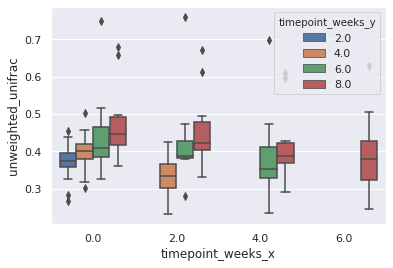

In [45]:
sns.boxplot(data=dist_meta[(dist_meta['cohort_x'] == 'BMT') & (dist_meta['cohort_y'] == 'BMT') & 
                           (dist_meta['host_subject_id_x'] == dist_meta['host_subject_id_y'])],
            y='unweighted_unifrac', x='timepoint_weeks_x', hue='timepoint_weeks_y')

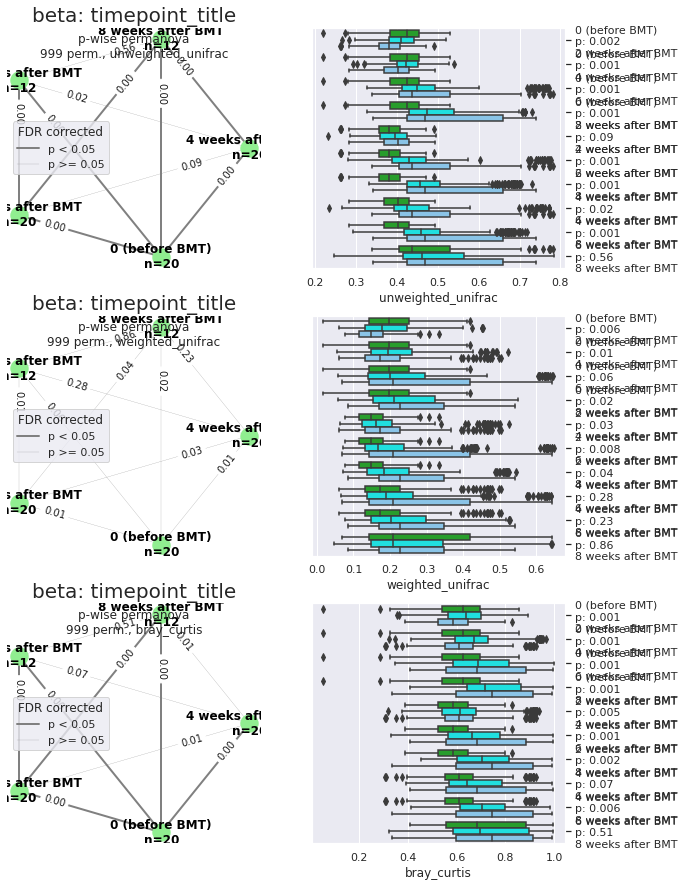

In [46]:
p = plotNetworks('timepoint_title', meta[meta['cohort'] == 'BMT'], None, res_all['beta_diversity']['results'], summarize=False)[0]

In [47]:
sns.color_palette("viridis", 5).as_hex()

['#443983', '#31688e', '#21918c', '#35b779', '#90d743']

# ETV6-RUNX1
**Reviewer 1**: "While these results are interesting, my main concern is the authors' claim that subclinical genetic predisposition to leukemia shapes a gut microbiota that is distinct from the microbiota of healthy individuals. In this study, the defect in B cell development in a Pax5 deficient mouse model may in itself be driving the changes evident in the microbiome; rather than Pax5+/- being a preleukemic condition. This makes the second point in results (above) difficult to interpret. Although this is difficult to tease out, it would be more useful to know what effect the microbiome has in a mouse preleukemic model that does not perturb mature B cell development, such as ETV6-RUNX1. As the authors have considerable experience with this model too, I wonder if they have any data from these mice to strengthen the paper. Or can they provide details of the gut microbiome of other mouse strains that have defective B cell production?"

--> Show that also the mutation ETV6-RUNX1 has an impact on the microbiome - as Pax5. Here, B-cell development is assumed to be undisturbed.


In [7]:
meta[(meta['cohort'].isin(['cohousing', 'ETV6RUNX1']))].groupby(['genotype', 'facility', 'cage_genotype']).size()

genotype    facility  cage_genotype 
ETV6-RUNX1  CF        ETV6-RUNX1         3
            SPF       ETV6-RUNX1        12
Pax5+/-     CF        Pax5+/-           12
                      Pax5+/- and WT    12
            SPF       Pax5+/-           12
                      Pax5+/- and WT    12
WT          CF        Pax5+/- and WT    12
                      WT                12
            SPF       Pax5+/- and WT    12
                      WT                12
dtype: int64

We need to exclude samples from cages with mice of Pax5 and WT genotype, since we know that their microbiomes are mixed.

In [12]:
res_fsr = redundancy_analysis_beta(
    meta[(meta['cohort'].isin(['cohousing', 'ETV6RUNX1'])) & (meta['cage_genotype'] != 'Pax5+/- and WT')], 
    #meta[(meta['qiita_study_id'].isin(['11758','12981'])) & (meta['cage_genotype'] != 'Pax5+/- and WT')],
    res_all['beta_diversity']['results']['unweighted_unifrac'], 'unweighted_unifrac',
    categorials=['genotype', 'facility', 'run_date'],
    title='unweighted UniFrac',
    dry=False, wait=False)
_savefig(res_fsr['results']['figure'], 'etv6runx1_C_effectsize')
#meta['wildtype'] = meta['genotype'].apply(lambda x: x if x=='WT' else 'Pax5 or ETV6RUNX1')
#meta_e6r1 = meta[(meta['facility'] == 'SPF') & (meta['qiita_study_id'].isin([ID_COHOUSING, ID_E6R1])) & (meta['cage_genotype'] != 'Pax5+/- and WT')]

Working directory is '/homes/sjanssen/TMP/ana_fRDAbeta_omqkfv2l', cachefile is '.anacache/03271b6018f638fd762c676e0f33995e.fRDAbeta'. /homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05279212802285894 and the largest is 13.309370014322404.
  RuntimeWarning
You provided 63 and 657 samples in metadata and beta respectively. Merging to 60 samples for further analysis.
Now wait until 471 job finishes.


TypeError: 'NoneType' object is not subscriptable

To reduce noise, we should only focus on the 12 ETV6-RUNX1 samples from SPF, and ignore the 3 ETV6-RUNX1 samples from CF.

Furthermore, I don't think we need to stratefy according to run date, since this effect seems to be smaller than genotype.

In [51]:
meta_etv6 = meta[(meta['cohort'].isin(['cohousing', 'ETV6RUNX1'])) & 
     (meta['cage_genotype'] != 'Pax5+/- and WT') & 
     (meta['facility'] == 'SPF')].copy()
meta_etv6.groupby(['facility', 'genotype', 'run_date']).size().to_frame().rename(columns={0: '# samples'})

# samples
facility genotype   run_date             
SPF      ETV6-RUNX1 2018-10-05          4
                    2020-02-03          8
         Pax5+/-    2018-10-01          7
                    2018-10-05          5
         WT         2018-10-01          6
                    2018-10-05          6

## SourceTracking for ETV6-RUNX1 samples to determin if they are closer to WT or Pax5+/-

Reduced to 34 samples (feature-table had 657, metadata had 36 samples)
Using existing results from '.anacache/82b6cc6f5b068e4201196a8fdcb2f0c0.sourcetracker2'. 


12 samples left with metadata and counts.
raw counts: 12
raw meta: 36
meta with counts: 12 samples x 116 fields
counts with meta: 12


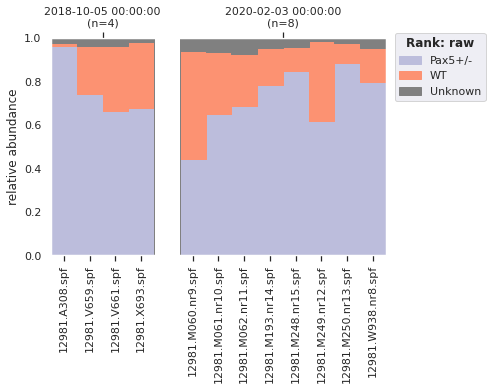

In [53]:
meta_etv6['Env'] = meta_etv6['genotype']
meta_etv6['SourceSink'] = meta_etv6['genotype'].apply(lambda x: 'sink' if x == 'ETV6-RUNX1' else 'source')
res_st2 = sourcetracker2(res_all['rarefaction']['results'], meta_etv6, col_envname='Env', col_type='SourceSink', dry=False, wait=False)

p_st2 = plotTaxonomy(
    res_st2['results'], meta_etv6, rank='raw', minreadnr=0, file_taxonomy=pd.Series(),
    group_l1='run_date', 
    print_sample_labels=True,
    colors={'Pax5+/-': colors_srtr['SPF@tp01@Pax5+/-'], 'WT': colors_srtr['SPF@tp01@WT'], 'Unknown': 'gray'}
)

Reduced to 34 samples (feature-table had 657, metadata had 36 samples)
Using existing results from '.anacache/1aeb4e0668cf4f1fc9cdccac917e8af5.feast'. 


12 samples left with metadata and counts.
raw counts: 12
raw meta: 36
meta with counts: 12 samples x 116 fields
counts with meta: 12


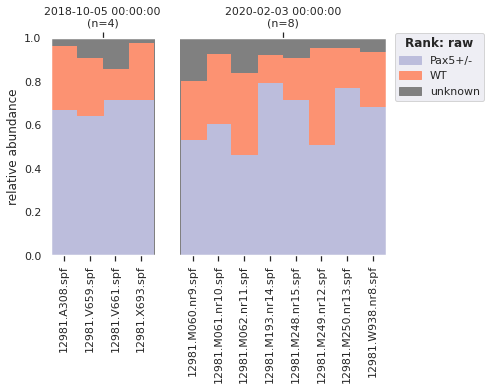

In [55]:
res_feast = feast(res_all['rarefaction']['results'], meta_etv6, col_envname='Env', col_type='SourceSink', dry=False, wait=False)
p_feast = plotTaxonomy(
    res_feast['results'], meta_etv6, rank='raw', minreadnr=0, file_taxonomy=pd.Series(),
    group_l1='run_date', 
    print_sample_labels=True,
    colors={'Pax5+/-': colors_srtr['SPF@tp01@Pax5+/-'], 'WT': colors_srtr['SPF@tp01@WT'], 'unknown': 'gray'}
)

ETV6-RUNX1 samples do look different from wildtype microbiomes, since FEAST (SourceTracker alternative) assigns less than 50% of their composition as being WT-alike.

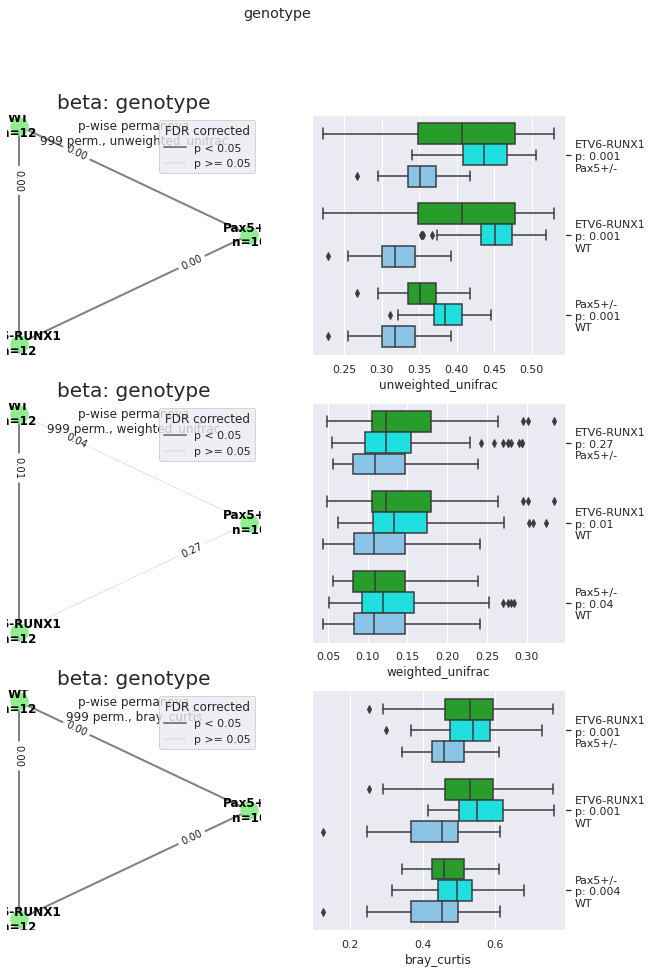

In [56]:
pBeta = plotNetworks('genotype', meta_etv6, None, res_all['beta_diversity']['results'], name='genotype')
#_savefig(pBeta, 'permanova_genotype')

Looking at beta-diversity distances: there are significant differences (PERMANOVA 999 permutations) between WT / Pax5 and ETV6-RUNX1

Due to insufficient power, we cannot inspect alpha diversity.

108 taxa left after collapsing to Family.
34 samples left with metadata and counts.
26 taxa left after filtering low abundant.
raw counts: 657
raw meta: 36
meta with counts: 34 samples x 116 fields
counts with meta: 34


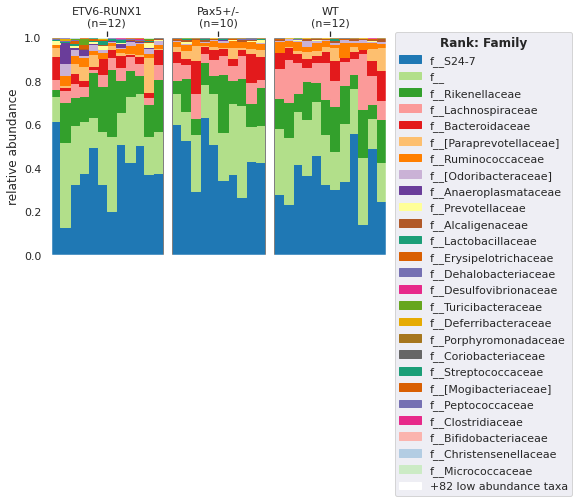

In [57]:
p = plotTaxonomy(res_all['rarefaction']['results'], meta_etv6, file_taxonomy=res_all['taxonomy']['RDP']['results']['Taxon'],
                 group_l1='genotype', rank='Family')

Looking at taxonomy plots do not reveal statistically significant differences in microbial composition.

identify_important_features: retrieved results from cache "Workdir/rf_e6r1.cache".


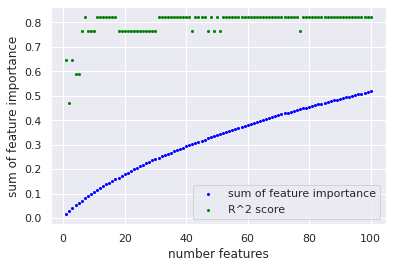

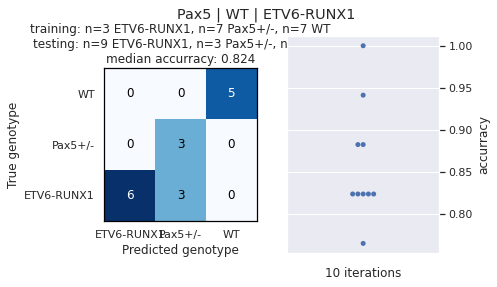

In [58]:
res_randomforest = identify_important_features(
    meta_etv6['genotype'],
    res_all['rarefaction']['results'],
    test_size=0.5, num_trees=1000, cache_filename=fp_workdir+"rf_e6r1.cache")
_ = plot_identify_important_features(res_randomforest)

fig_homogeneous, clf = randomForest_phenotype(
    res_all['rarefaction']['results'].loc[res_randomforest.iloc[10,:]['features'], set(res_all['rarefaction']['results'].columns) & set(meta_etv6.index)],
    meta_etv6['genotype'], title='Pax5 | WT | ETV6-RUNX1', iterations=10)
#_savefig(fig_homogeneous, 'rf_genotype')

A random forest with only 10 most important features can clearly separate between all three genotypes --> Pax5 and ETV6-RUNX1 incude significant difference in microbial composition. Caveat: sample sizes are quite small

# Metabolome

In [143]:
meta_chems = pd.read_excel("Incoming/Serum samples for bacterial metabolites analysis - sent on 13-01-2020.xlsx", sheet_name="Murine serum samples").rename(columns={'tube_number': 'sample_name'})
meta_chems['sample_name'] = meta_chems['sample_name'].astype(str)
meta_chems = meta_chems.set_index('sample_name')

x = pd.read_excel('Incoming/200604__Data_20-0005.xlsx', sheet_name="01.AllData_added columns").rename(columns={'Sample.label.on.tube': 'sample_name'})
x['sample_name'] = x['sample_name'].astype(str)
data = x[['sample_name', "compound.method", "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier", "compound.name"]].set_index(['sample_name', 'compound.name'])
counts_chems = pd.pivot_table(data=data, columns='sample_name', index="compound.name", values="relativeResponse").fillna(0)
# remove compounds containing 'unknown' in its name
counts_chems = counts_chems.loc[[c for c in counts_chems.index if 'unknown' not in c], :]

In [144]:
res_all_chems = {
    'alpha_diversity': alpha_diversity(counts_chems, metrics=['shannon'], dry=False, wait=False, rarefaction_depth=None),
    'beta_diversity': beta_diversity(counts_chems, metrics=['bray_curtis', 'jaccard'], dry=False, wait=False)
}
if res_all_chems['alpha_diversity']['results'] is not None:
    res_all_chems['alpha_diversity']['results'].index = list(map(str, res_all_chems['alpha_diversity']['results'].index))

if res_all_chems['beta_diversity']['results'] is not None:
    res_all_chems['emperor'] = emperor(meta_chems, res_all_chems['beta_diversity']['results'], fp_results=fp_generated+'/Emperor/', dry=False, wait=False, infix='_metabolome_')
    
# for dsFDR
fp_diffabund = fp_workdir + '/metabolome_diffabund.biom'
pandas2biom(fp_diffabund, counts_chems)
fp_meta = fp_workdir + '/metabolome_diffabund_meta.tsv'
meta_chems.to_csv(fp_meta, sep="\t", index=True)
dsFDR_experiment = ca.read_amplicon(fp_diffabund, fp_meta, min_reads=0, normalize=10000)

Using existing results from '.anacache/22c332cc64c5ef45ae9b80cd494a1871.adiv'. 
Using existing results from '.anacache/3dd931cf7e27ac6585b6533f143d9e11.bdiv'. 
found matching working dir "/homes/sjanssen/TMP/ana_emperor_4lfpnrk3"
 Was removed.


## Genotype

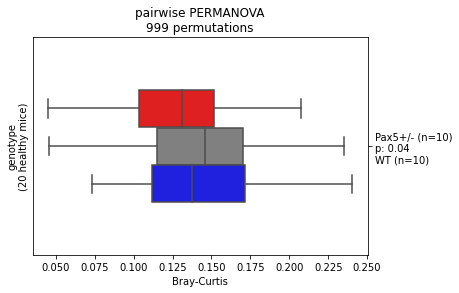

In [147]:
field = 'genotype'
field_meta = meta_chems[meta_chems['diseased'] == 'no'][field]
b = detect_distant_groups(res_all_chems['beta_diversity']['results']['bray_curtis'], 'Bray-Curtis', field_meta)
ax, _ = plotGroup_permanovas(res_all_chems['beta_diversity']['results']['bray_curtis'], field_meta, **b,
                             horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'red', 'right': 'blue'})
ax.set_ylabel(field+ "\n(%i healthy mice)" % field_meta.shape[0])
ax.yaxis.label.set_visible(True)
_ = ax.set_title('pairwise %s\n%s permutations' % (str.upper(b['fct_name']), b['num_permutations']))
_savefig(ax.get_figure(), 'metabolome_beta_genotype')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=29)
     6 (of   52) taxa different between 'Pax5+/-' (n=10) vs. 'WT' (n=10)



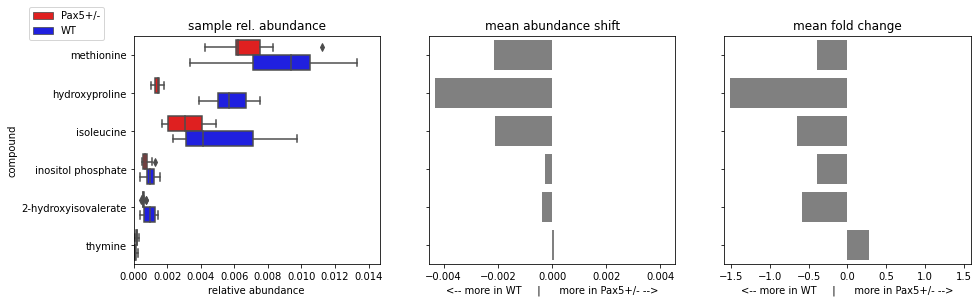

In [149]:
field = 'genotype'
res_dsFDR_genotype = find_diff_taxa(dsFDR_experiment, meta_chems[meta_chems['diseased'] == 'no'], [field])
if len(res_dsFDR_genotype) > 0:
    p = plot_diff_taxa(counts_chems, meta_chems[meta_chems['diseased'] == 'no'][field], res_dsFDR_genotype,
                       min_mean_abundance=0.0, topXfeatures=10,
                       colors_boxplot={'Pax5+/-': 'red', 'WT': 'blue'}, color_barplot='gray')
    p[0].get_axes()[0].set_ylabel("compound")
    p[0].suptitle("")
    _savefig(p[0], 'metabolome_dsfdr_%s' % field)

## Sick / Healthy

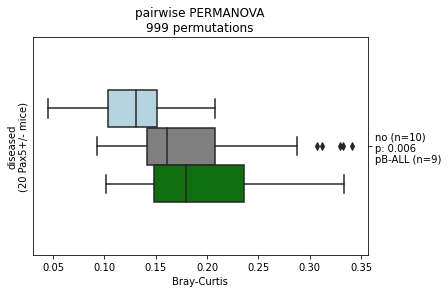

In [148]:
field = 'diseased'
field_meta = meta_chems[meta_chems['genotype'] == 'Pax5+/-'][field]
b = detect_distant_groups(res_all_chems['beta_diversity']['results']['bray_curtis'], 'Bray-Curtis', field_meta)
ax, _ = plotGroup_permanovas(res_all_chems['beta_diversity']['results']['bray_curtis'], field_meta, **b,
                             horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'lightblue', 'right': 'green'})
ax.set_ylabel(field+ "\n(%i Pax5+/- mice)" % field_meta.shape[0])
ax.yaxis.label.set_visible(True)
_ = ax.set_title('pairwise %s\n%s permutations' % (str.upper(b['fct_name']), b['num_permutations']))
_savefig(ax.get_figure(), 'metabolome_beta_diseased')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=29)
    15 (of   52) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=9)



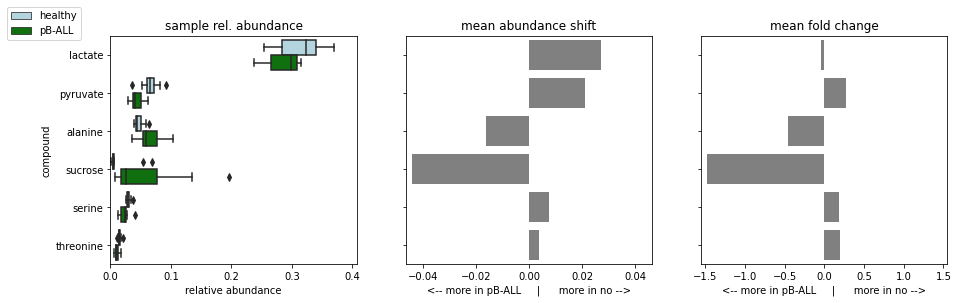

In [152]:
field = 'diseased'
res_dsFDR_sickhealthy = find_diff_taxa(dsFDR_experiment, meta_chems[meta_chems['genotype'] == 'Pax5+/-'], [field])
if len(res_dsFDR_sickhealthy) > 0:
    p = plot_diff_taxa(counts_chems, meta_chems[meta_chems['genotype'] == 'Pax5+/-'][field], res_dsFDR_sickhealthy,
                       min_mean_abundance=0.0, topXfeatures=6,
                       colors_boxplot={'no': 'lightblue', 'pB-ALL': 'green'}, color_barplot='gray')
    p[0].get_axes()[0].set_ylabel("compound")
    for t in p[0].get_axes()[0].get_legend().get_texts():
        if t.get_text() == 'no':
            t.set_text('healthy')
    p[0].suptitle("")
    _savefig(p[0], 'metabolome_dsfdr_%s' % field)

**Legend for figure**
After removing additional four peaks with annotation uncertainty, we used the "relative response" values for the remaining 52 quality controlled gas chromatography peaks to create a feature table. Using Bray-Curtis, we computed a beta-diversity distance matrix via Qiime2 version 2020.2. Panel A shows the PCoA of the resulting matrix, were blood samples from WT mice are colored blue, Pax5+/- samples are red. Red rings indicate samples from mice which were antibotica treated and developed pB-ALL over time. Panel B shows statistically significant (two-sided PERMANOVA tests with 999 permutations) differences in beta-diversity between blood samples from WT (blue) and Pax5+/- (red) mice. Gray box summarizes inter-groups distances, i.e. pairs of samples were one partner belongs to WT and the other to Pax5+/-. C) Applying dsFDR on the metabolite feature table, 6 of 52 compounds are found to be significantly differentially abundant between the 10 WT and 10 Pax5+/- blood samples. Panel D) shows the mean abundance shift for those compounds, while E) indicates their mean fold change. Panels F to I visualize results for differences between blood samples from 10 healthy Pax5+/- (light blue = red solid spheres in Panel A) and 10 pB-ALL diseased (dark green = red rings in Panel A) individual mice accordingly. Panels F to I visualize the top 6 of 16 compounds found to be significantly differentially abundant between all 52 compounds in healthy and pB-ALL samples.